In [1]:
!pip install wfdb neurokit2 torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 102.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wfdb
import neurokit2 as nk

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
record_name = "100"
record = wfdb.rdrecord(record_name, pn_dir="mitdb")

signal = record.p_signal[:, 0]  # Lead MLII
fs = record.fs

print("Sampling rate:", fs)
print("Signal length:", signal.shape)

Sampling rate: 360
Signal length: (650000,)


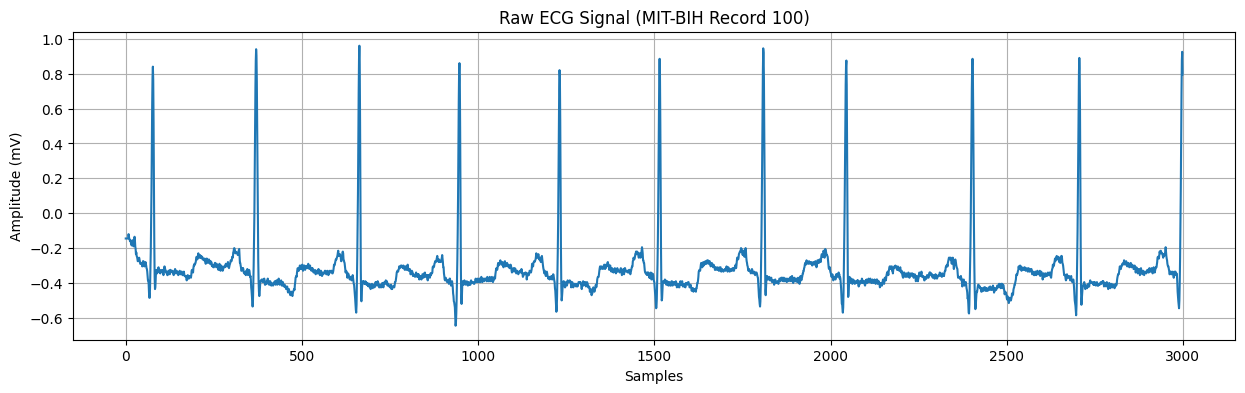

In [4]:
plt.figure(figsize=(15,4))
plt.plot(signal[:3000])
plt.title("Raw ECG Signal (MIT-BIH Record 100)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()


## Dataset Overview

The MIT-BIH Arrhythmia Database is a widely used benchmark dataset for ECG analysis.
Signals are sampled at 360 Hz and annotated by clinical experts. In this project, the MLII lead is used due to its clinical relevance and widespread adoption in arrhythmia detection studies.


In [5]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, fs, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

filtered_ecg = bandpass_filter(signal, fs)

In [6]:
cleaned_ecg = nk.ecg_clean(filtered_ecg, sampling_rate=fs, method="neurokit")

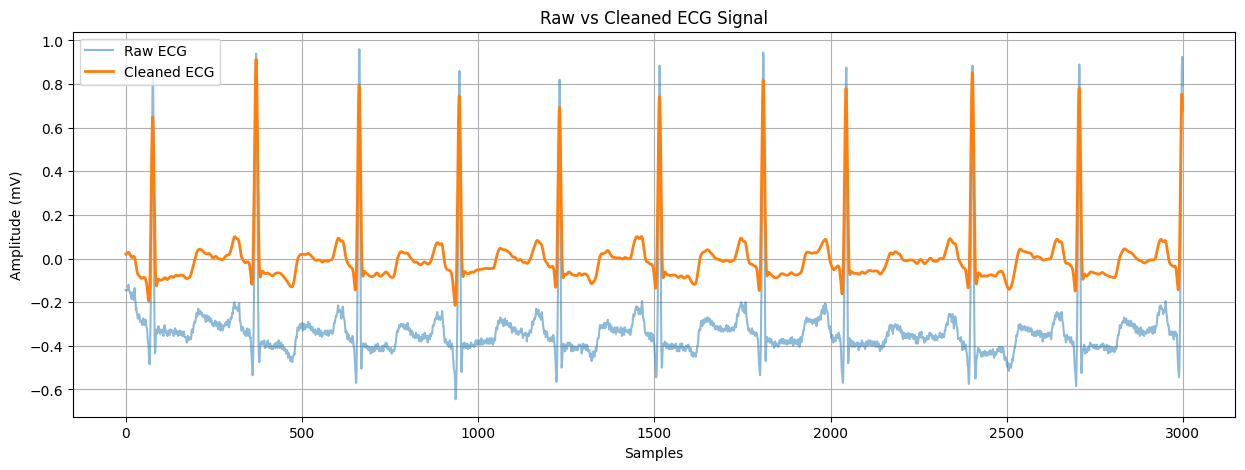

In [7]:
plt.figure(figsize=(15,5))
plt.plot(signal[:3000], label="Raw ECG", alpha=0.5)
plt.plot(cleaned_ecg[:3000], label="Cleaned ECG", linewidth=2)
plt.legend()
plt.title("Raw vs Cleaned ECG Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

In [8]:
signals, info = nk.ecg_peaks(cleaned_ecg, sampling_rate=fs)
r_peaks = info["ECG_R_Peaks"]

print("Number of detected R-peaks:", len(r_peaks))

Number of detected R-peaks: 2270


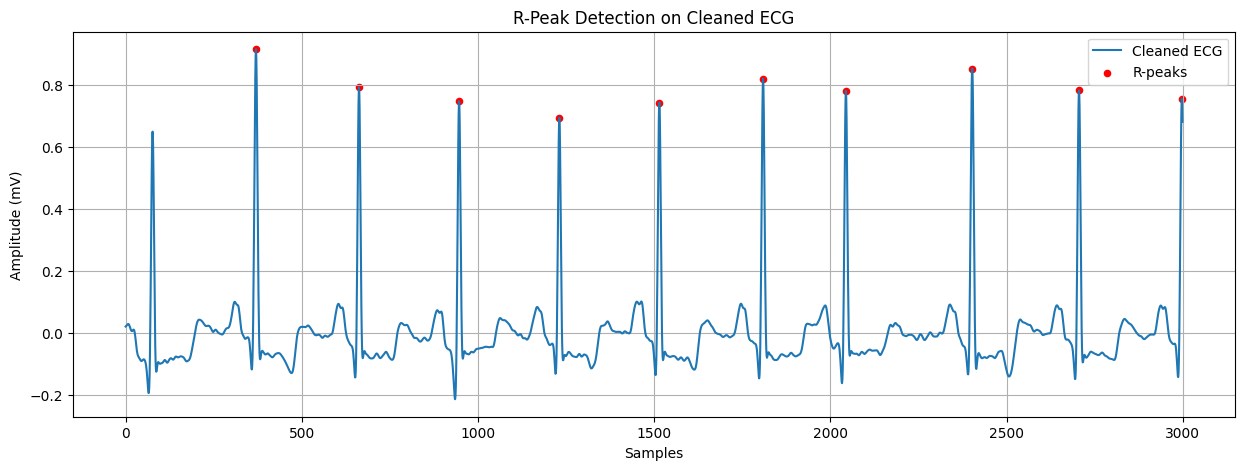

In [9]:
plt.figure(figsize=(15,5))
plt.plot(cleaned_ecg[:3000], label="Cleaned ECG")
plt.scatter(
    r_peaks[r_peaks < 3000],
    cleaned_ecg[r_peaks[r_peaks < 3000]],
    color="red",
    s=20,
    label="R-peaks"
)
plt.legend()
plt.title("R-Peak Detection on Cleaned ECG")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

## ECG Signal Preprocessing

Raw ECG signals were preprocessed using a combination of bandpass filtering and signal cleaning techniques to remove baseline wander and high-frequency noise. R-peaks were detected using a Pan–Tompkins-inspired algorithm to enable accurate heartbeat segmentation for downstream deep learning analysis.


In [10]:
pre_r = int(0.2 * fs)
post_r = int(0.4 * fs)
window_size = pre_r + post_r

print("Window size (samples):", window_size)

Window size (samples): 216


In [11]:
beats = []

for r in r_peaks:
    start = r - pre_r
    end = r + post_r

    if start >= 0 and end < len(cleaned_ecg):
        beat = cleaned_ecg[start:end]
        beats.append(beat)

beats = np.array(beats)
print("Total beats extracted:", beats.shape)

Total beats extracted: (2270, 216)


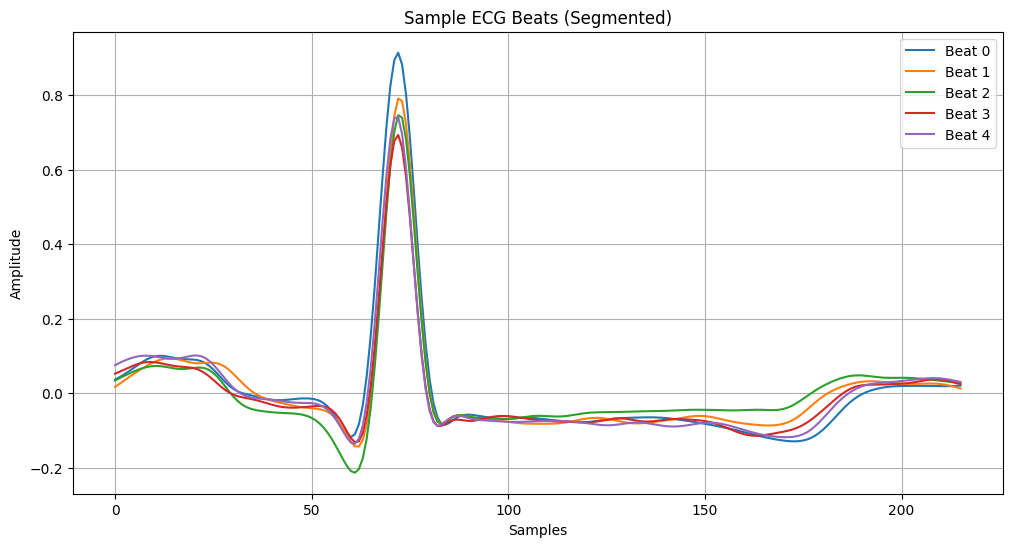

In [12]:
plt.figure(figsize=(12,6))

for i in range(5):
    plt.plot(beats[i], label=f"Beat {i}")

plt.title("Sample ECG Beats (Segmented)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
beats_norm = (beats - np.mean(beats, axis=1, keepdims=True)) / (
    np.std(beats, axis=1, keepdims=True) + 1e-8
)

In [15]:
X = torch.tensor(beats_norm, dtype=torch.float32)
X = X.unsqueeze(1)

print("Tensor shape:", X.shape)


Tensor shape: torch.Size([2270, 1, 216])


In [16]:
class ECGBeatDataset(Dataset):
    def __init__(self, signals):
        self.signals = signals

    def __len__(self):
        return self.signals.shape[0]

    def __getitem__(self, idx):
        return self.signals[idx]

In [17]:
dataset = ECGBeatDataset(X)

In [18]:
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

batch = next(iter(dataloader))
batch.shape

torch.Size([32, 1, 216])

## Beat Segmentation and Dataset Construction

Each ECG signal was segmented into individual heartbeats centered around detected R-peaks. Fixed-length windows were extracted to ensure consistent input dimensions for deep learning models. Beat-level normalization was applied to preserve morphological patterns while reducing inter-beat amplitude variability.


In [19]:
annotation = wfdb.rdann(record_name, "atr", pn_dir="mitdb")

ann_samples = annotation.sample
ann_symbols = annotation.symbol

print("Total annotations:", len(ann_symbols))

Total annotations: 2274


In [20]:
arrhythmia_symbols = [
    "V",  # PVC
    "A",  # Atrial premature
    "L", "R",  # Bundle branch blocks
    "F",  # Fusion
    "E"   # Ventricular escape
]

In [21]:
labels = []

valid_r_peaks = []

for r in r_peaks:
    start = r - pre_r
    end = r + post_r

    if start >= 0 and end < len(cleaned_ecg):
        idx = np.argmin(np.abs(ann_samples - r))
        symbol = ann_symbols[idx]

        label = 1 if symbol in arrhythmia_symbols else 0

        labels.append(label)
        valid_r_peaks.append(r)

labels = np.array(labels)

print("Label distribution:", np.bincount(labels))

Label distribution: [2237   33]


In [22]:
print("X shape:", X.shape)
print("y shape:", labels.shape)

X shape: torch.Size([2270, 1, 216])
y shape: (2270,)


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: torch.Size([1816, 1, 216]) Test: torch.Size([454, 1, 216])


In [24]:
class ECGBeatDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.signals.shape[0]

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

In [25]:
train_dataset = ECGBeatDataset(X_train, y_train)
test_dataset = ECGBeatDataset(X_test, y_test)

In [26]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

## Beat-Level Labeling and Dataset Split

Each segmented heartbeat was labeled based on expert annotations provided in the MIT-BIH database. Beats were categorized into normal and arrhythmic classes. The dataset was split into training and test sets using stratified sampling to preserve class distribution and prevent data leakage.

In [27]:
class ECGCNN(nn.Module):
    def __init__(self):
        super(ECGCNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)

        self.pool = nn.MaxPool1d(2)
        self.gap = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECGCNN().to(device)
print(model)

sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch.to(device)

out = model(sample_batch)
print("Output shape:", out.shape)

ECGCNN(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Output shape: torch.Size([32, 2])


In [29]:
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()

weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [32]:
from sklearn.metrics import classification_report

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))

In [33]:
num_epochs = 10

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss:.4f}")

print("\nTest set evaluation:")
evaluate(model, test_loader)

Epoch [1/10] - Loss: 0.5513
Epoch [2/10] - Loss: 0.5315
Epoch [3/10] - Loss: 0.5340
Epoch [4/10] - Loss: 0.5073
Epoch [5/10] - Loss: 0.5302
Epoch [6/10] - Loss: 0.4942
Epoch [7/10] - Loss: 0.5024
Epoch [8/10] - Loss: 0.4724
Epoch [9/10] - Loss: 0.4737
Epoch [10/10] - Loss: 0.4818

Test set evaluation:
              precision    recall  f1-score   support

           0     0.9911    0.9933    0.9922       447
           1     0.5000    0.4286    0.4615         7

    accuracy                         0.9846       454
   macro avg     0.7455    0.7109    0.7269       454
weighted avg     0.9835    0.9846    0.9840       454



## Deep Learning Model

A 1D convolutional neural network was employed to learn discriminative patterns from beat-level ECG segments. Class imbalance was addressed using weighted cross-entropy loss. The proposed architecture was intentionally kept compact to reduce overfitting while maintaining interpretability for explainable AI analysis.


In [34]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def forward_hook(module, input, output):
    global activations
    activations = output

In [35]:
model.conv2.register_forward_hook(forward_hook)
model.conv2.register_backward_hook(backward_hook)

In [36]:
model.eval()

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    outputs = model(x)
    preds = torch.argmax(outputs, dim=1)

    idx = (preds == 1).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        beat = x[idx[0]].unsqueeze(0)
        label = y[idx[0]].item()
        break

print("True label:", label)

True label: 0


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [37]:
model.zero_grad()
output = model(beat)
score = output[0, 1]
score.backward()

In [38]:
weights = torch.mean(gradients, dim=2)
cam = torch.sum(weights[:, :, None] * activations, dim=1)
cam = torch.relu(cam)
cam = cam.squeeze().cpu().detach().numpy()

cam = cam / np.max(cam)

In [40]:
import cv2

signal_length = beat.shape[-1]

cam_resized = np.interp(
    np.linspace(0, len(cam) - 1, signal_length),
    np.arange(len(cam)),
    cam
)


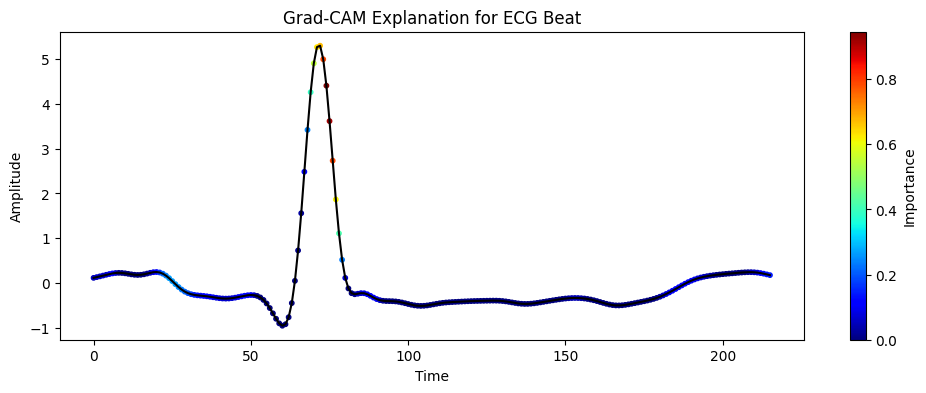

In [41]:
signal = beat.squeeze().cpu().numpy()

plt.figure(figsize=(12,4))
plt.plot(signal, label="ECG Beat", color="black")

plt.scatter(
    range(len(signal)),
    signal,
    c=cam_resized,
    cmap="jet",
    s=10,
    label="Grad-CAM"
)

plt.colorbar(label="Importance")
plt.title("Grad-CAM Explanation for ECG Beat")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

## Explainability via Grad-CAM

Grad-CAM was employed to interpret the predictions of the deep learning model at the waveform level. The resulting heatmaps highlight critical temporal regions of the ECG signal that contribute most strongly to arrhythmia classification decisions. Notably, the model focuses on regions corresponding to abnormal QRS morphology, aligning with established clinical knowledge.


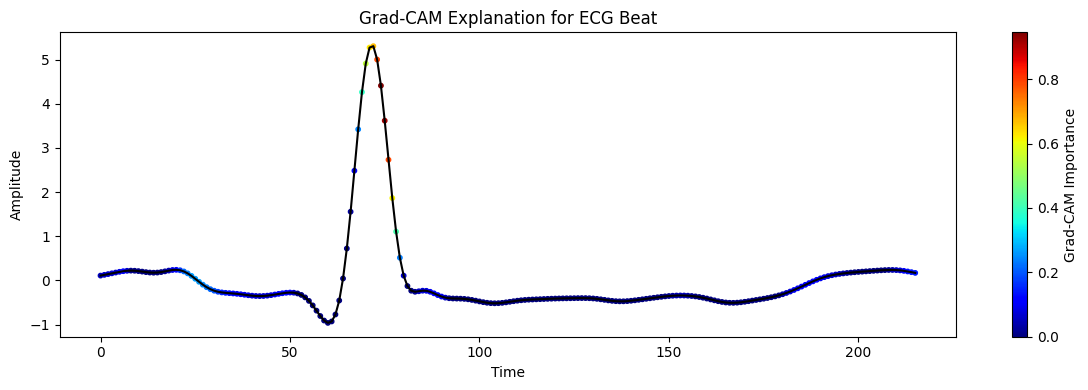

In [42]:
plt.figure(figsize=(12,4))
plt.plot(signal, label="ECG Beat", color="black")

plt.scatter(
    range(len(signal)),
    signal,
    c=cam_resized,
    cmap="jet",
    s=10
)

plt.colorbar(label="Grad-CAM Importance")
plt.title("Grad-CAM Explanation for ECG Beat")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.savefig("gradcam_ecg_beat.png", dpi=300)
plt.show()

In [44]:
def compute_gradcam(model, beat, target_class):
    global gradients, activations

    model.zero_grad()
    output = model(beat)
    score = output[0, target_class]
    score.backward()

    weights = torch.mean(gradients, dim=2)
    cam = torch.sum(weights[:, :, None] * activations, dim=1)
    cam = torch.relu(cam)
    cam = cam.squeeze().cpu().detach().numpy()

    cam = cam / np.max(cam)

    signal_length = beat.shape[-1]
    cam_resized = np.interp(
        np.linspace(0, len(cam) - 1, signal_length),
        np.arange(len(cam)),
        cam
    )

    return cam_resized

In [45]:
model.eval()

normal_beat = None
arrhythmia_beat = None

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    outputs = model(x)
    preds = torch.argmax(outputs, dim=1)

    for i in range(len(y)):
        if y[i] == 0 and normal_beat is None:
            normal_beat = x[i].unsqueeze(0)
        if y[i] == 1 and preds[i] == 1 and arrhythmia_beat is None:
            arrhythmia_beat = x[i].unsqueeze(0)

    if normal_beat is not None and arrhythmia_beat is not None:
        break

In [46]:
if arrhythmia_beat is None:
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(y)):
            if preds[i] == 1:
                arrhythmia_beat = x[i].unsqueeze(0)
                break
        if arrhythmia_beat is not None:
            break

In [47]:
cam_normal = compute_gradcam(model, normal_beat, target_class=0)
cam_arrhythmia = compute_gradcam(model, arrhythmia_beat, target_class=1)

signal_normal = normal_beat.squeeze().cpu().numpy()
signal_arrhythmia = arrhythmia_beat.squeeze().cpu().numpy()

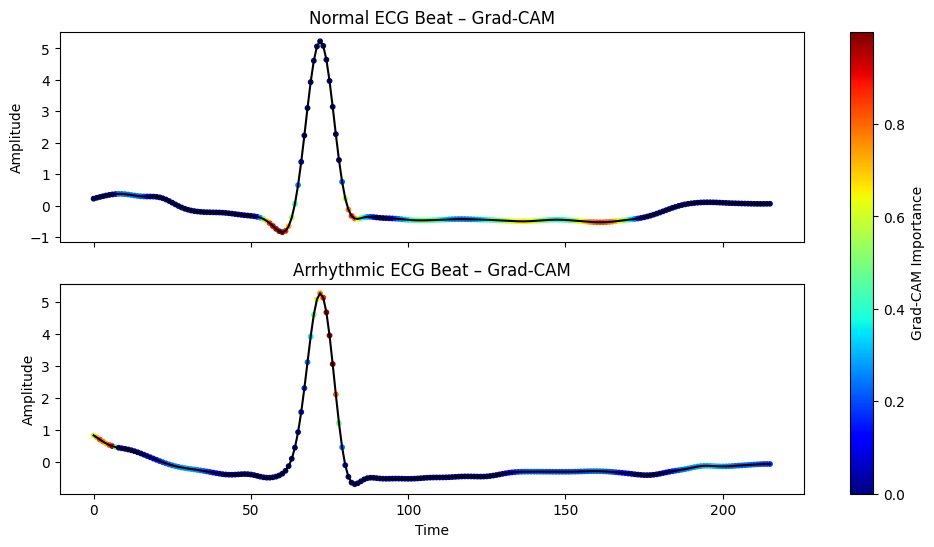

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)
axes[0].plot(signal_normal, color="black")
sc0 = axes[0].scatter(
    range(len(signal_normal)),
    signal_normal,
    c=cam_normal,
    cmap="jet",
    s=10
)
axes[0].set_title("Normal ECG Beat – Grad-CAM")
axes[0].set_ylabel("Amplitude")

axes[1].plot(signal_arrhythmia, color="black")
sc1 = axes[1].scatter(
    range(len(signal_arrhythmia)),
    signal_arrhythmia,
    c=cam_arrhythmia,
    cmap="jet",
    s=10
)
axes[1].set_title("Arrhythmic ECG Beat – Grad-CAM")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Amplitude")

fig.colorbar(sc1, ax=axes, label="Grad-CAM Importance")
plt.savefig("gradcam_comparison_normal_vs_arrhythmia.png", dpi=300)
plt.show()


Thank you for taking the time to explore this project, run the code, and review the implementation.  
Your feedback, suggestions, and contributions are greatly appreciated and can help improve this project.
 follow me on...

Linkedin : www.linkedin.com/in/ali-mohamaadpour